In [57]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> State update </h1>

In [58]:
def update_state(c,b,g_0,omega_tab,omega_A,L,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k, 0>
    b (float): Atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (float): Updated atomic coefficient.
    """
    g_matrix_individual = 1j * g_0 * np.sqrt(omega_A / L) * np.exp(-1j * (omega_tab - omega_A) * t)
    g_matrix = np.concatenate((g_matrix_individual, g_matrix_individual))

    b_new = c @ g_matrix
    c_new = b * np.conjugate(g_matrix)

    return -1j* dt * c_new, -1j * dt * b_new

<h1> RG Scheme </h1>

In [29]:
def RG_scheme(c_init, b_init, g_0, omega_tab, omega_A, L, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k, 0>
    b_init (float): initial atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(c_init)//2
    c_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)
    b_array = np.zeros(nb_pts_time, dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b_array[0] = b_init

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b_current = b_array[i-1]

        c_new_k1, b_new_k1 = update_state(c_current, b_current, g_0, omega_tab, omega_A, L, t, dt)
        c_new_k2, b_new_k2 = update_state(c_current + c_new_k1/2, b_current + b_new_k1/2, g_0, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k3, b_new_k3 = update_state(c_current + c_new_k2/2, b_current + b_new_k2/2, g_0, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k4, b_new_k4 = update_state(c_current + c_new_k3, b_current + b_new_k3, g_0, omega_tab, omega_A, L, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b_new = b_current + (b_new_k1 + 2*b_new_k2 + 2*b_new_k3 + b_new_k4) / 6

        c_array[i] = c_new
        b_array[i] = b_new

    return c_array, b_array 
    

<h1> Function that treats the whole evolution </h1>

In [30]:
def get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes = False, progress_bar=True):
    """
    Generate data for the RG scheme with a mirror.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k, 0>.
    b_array (np array): Coefficients in front of the state |0, 1>.
    omega_tab (np array): Array of frequencies.
    """
    
    #quantization of the modes
    omega_tab_individual = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab_individual = np.copy(omega_tab_individual)
    n_modes = len(k_tab_individual)

    if print_nb_modes:
        print("Number of modes: ", n_modes)
    
    #prepare the initial state
    print("Preparing the initial state...")
    c_init = np.zeros(2*n_modes, dtype=complex)
    b_init = 0

    c_init_1 = np.exp(-(0.5*(k_tab_individual - omega_0)**2) * sigma**2) * np.exp(-1j * k_tab_individual * x_0)
    c_init = np.concatenate((c_init_1, np.zeros(n_modes))) #only one photon in the first channel
    c_init /= np.sqrt(np.sum(np.abs(c_init)**2))  # Normalize the initial state

    ##evolve the state
    print("Evolving the state...")
    c_array, b_array = RG_scheme(c_init, b_init, g_0, omega_tab_individual, omega_A, L, T, dt, progress_bar=progress_bar)

    ##Compute overlap with the initial state
    print("Computing overlap with the initial state...")
    overlap_tab = np.zeros(int(T / dt), dtype=complex)
    for i in range(int(T / dt)):
        c_current = c_array[i]
        b_current = b_array[i]
        overlap_tab[i] = np.abs (np.conjugate(c_current) @ c_init + b_current * np.conjugate(b_init))**2


    return c_array, b_array, overlap_tab, k_tab_individual

<h1> First test </h1>

In [59]:
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 1
omega_A = 3
omega_0 = 3
gamma = g_0**2 * omega_A

omega_max = 10

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4

#check some parameters
print("50% Reflectivity for omega_0_m = ", omega_A - gamma, " and omega_0_p = ", omega_A + gamma)
print("Value of sigma ", sigma, " and life time of the excited state: ", 1/gamma)

50% Reflectivity for omega_0_m =  0  and omega_0_p =  6
Value of sigma  1.9634954084936207  and life time of the excited state:  0.3333333333333333


In [60]:
c_array, b_array, overlap_tab, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes=True)

Number of modes:  51
Preparing the initial state...
Evolving the state...


  0%|          | 0/1569 [00:00<?, ?it/s]

Computing overlap with the initial state...


<h1> Occupation numbers </h1>

In [61]:
time_array = np.linspace(0, T, int(T / dt))
# Prepare the k_tab for occupation numbers

n_modes = c_array.shape[1] //2
nb_pts_time = int(T / dt)
p_1 = np.zeros(nb_pts_time)
p_2 = np.zeros(nb_pts_time)
p_atom =  np.zeros(nb_pts_time)

for i in tqdm(range(nb_pts_time)):
    p_1[i] = np.sum(np.abs(c_array[i,:n_modes])**2)
    p_2[i] = np.sum(np.abs(c_array[i,n_modes:])**2)
    p_atom[i] = np.abs(b_array[i])**2    

  0%|          | 0/1570 [00:00<?, ?it/s]

Reflection probability = 0.9313553236724392


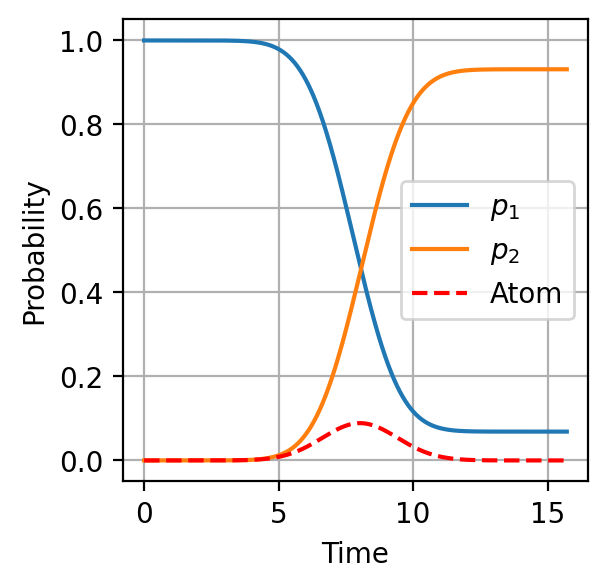

In [62]:
print("Reflection probability =", 1-p_1[-1])

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(time_array, p_1, label=r'$p_1$')
ax.plot(time_array, p_2, label=r'$p_2$')
ax.plot(time_array, p_atom, label='Atom', linestyle='--', color='red')   
#ax.plot(time_array, overlap_tab, label='Reflection (with overlap)', linestyle=':', color='green')
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
#ax.set_ylim(0, 1.1)
ax.legend()
ax.grid()

plt.show()

<h1> UV-cutoff check </h1>

I consider the incoming photon at reasonance with the atom and check the reflection probability against the UV-cutoff

In [79]:
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.5
omega_A = 10
omega_0 = 10
gamma = g_0**2 * omega_A

nb_freq = 50
p_1_tab = np.zeros(nb_freq)
omega_max_tab = np.linspace(omega_A + gamma, omega_A+10*gamma, nb_freq)

#initial photon wavepacket parameters
sigma = L/8
sigma_momentum = 1/sigma
x_0 = -L/4


for i in tqdm(range(nb_freq)):
    omega_max = omega_max_tab[i]
    print(f"Running for omega_max = {omega_max}")
    c_array, b_array, overlap_tab, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes=False, progress_bar=False)
    n_modes = len(k_tab)
    p_1_tab[i] = np.sum(np.abs(c_array[-1, :n_modes])**2) 

  0%|          | 0/50 [00:00<?, ?it/s]

Running for omega_max = 12.5
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_max = 12.959183673469388
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_max = 13.418367346938776
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_max = 13.877551020408163
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_max = 14.33673469387755
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_max = 14.795918367346939
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_max = 15.255102040816327
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_max = 15.71428571

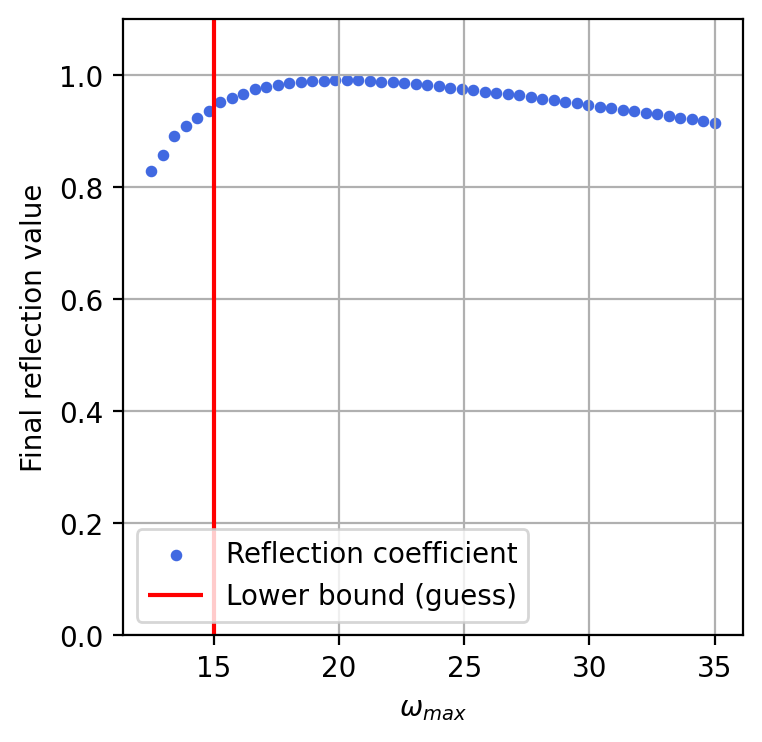

In [80]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=resol)
ax.scatter(omega_max_tab, 1-p_1_tab, marker='o', color="royalblue", label='Reflection coefficient', s=10)
ax.set_xlabel(r'$\omega_{max}$')
ax.vlines(omega_A + 2*gamma, 0, 3, label='Lower bound (guess)', color='red')
ax.set_ylabel('Final reflection value')
ax.set_ylim(0, 1.1)
ax.grid()
ax.legend()
plt.show()

<h1> Reflection against detunning </h1>

In [9]:
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.5
omega_A = 10
#omega_max = omega_A + 3*gamma
omega_max = 20
print("Omega_max = ", omega_max)

#initial photon wavepacket parameters
sigma = L/8
sigma_momentum = 1/sigma
x_0 = -L/4

gamma = g_0**2 * omega_A
print("50% Reflectivity for omega_0_m = ", omega_A - gamma, " and omega_0_p = ", omega_A + gamma)
print("Value of sigma ", sigma, " and life time of the excited state: ", 1/gamma)


Omega_max =  20
50% Reflectivity for omega_0_m =  7.5  and omega_0_p =  12.5
Value of sigma  3.9269908169872414  and life time of the excited state:  0.4


Run the calculations

In [ ]:
#get the number of modes
nb_freq = 39

omega_0_tab = np.linspace(max(omega_A - 2*gamma, 0), omega_A + 2*gamma, nb_freq)
#omega_0_tab = [1]
p_1_tab = np.zeros(nb_freq)

for i in tqdm(range(nb_freq)):
    omega_0 = omega_0_tab[i]
    print(f"Running for omega_0 = {omega_0}")
    c_array, b_array, overlap_tab, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes=False, progress_bar=False)
    n_modes = len(k_tab)
    p_1_tab[i] = np.sum(np.abs(c_array[-1, :n_modes])**2) 

  0%|          | 0/39 [00:00<?, ?it/s]

Running for omega_0 = 5.0
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 5.2631578947368425
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 5.526315789473684
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 5.7894736842105265
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 6.052631578947368
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 6.315789473684211
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 6.578947368421053
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 6.842105263157895
Preparing the

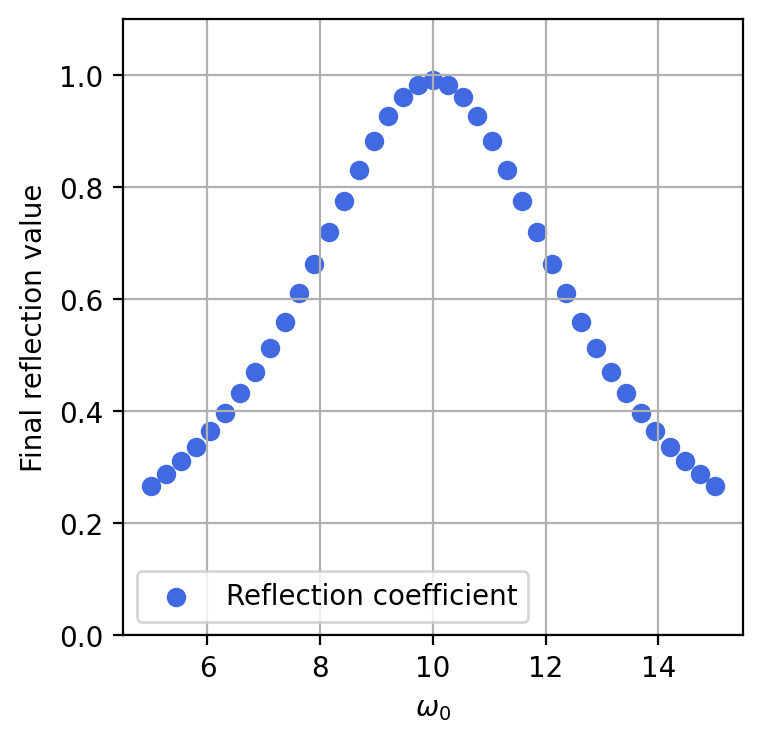

In [11]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=resol)
ax.scatter(omega_0_tab, 1-p_1_tab, marker='o', color="royalblue", label='Reflection coefficient')
ax.legend()
ax.set_xlabel(r'$\omega_0$')
ax.set_ylabel('Final reflection value')
ax.set_ylim(0, 1.1)
ax.grid()
plt.show()

<h1> Find physical parameters </h1>

In [22]:
#first, find the frequency that maximizes the reflection
omega_1_index = np.argmin(np.abs(p_1_tab))
omega_1 = omega_0_tab[omega_1_index]

#then, find the frequency that matches 50% reflection
omega_2_index = np.argmin(np.abs(p_1_tab - 0.5))
omega_2 = omega_0_tab[omega_2_index]

omega_A_phys = omega_1
gamma_phys = np.abs(omega_2 - omega_A_phys)
g_0_phys = np.sqrt(gamma_phys / omega_A_phys)

#sanity check
if 1-p_1_tab[omega_1_index] < 0.99:
    print("WARNING : Reflection not high enough at resonance. Maximal value reached =", 1-p_1_tab[omega_1_index])


print("Omega_A phys :", omega_A_phys)
print("g_0 phys :", g_0_phys)

Omega_A phys : 10.0
g_0 phys : 0.5380275868489705


Compute the corresponding theoretical predicitions to check consistency

In [23]:
omega_0_tab_theory = np.linspace(max(omega_A - 2*gamma, 0), omega_A + 2*gamma, 100)
omega_0_tab_simu = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])

theory_curve = 1 / (1 + (omega_0_tab_theory - omega_A_phys)**2 / (g_0_phys**2 * omega_A_phys)**2)

theory_curve_non_mono = np.zeros(100)

for i in range(100):
    omega_0_init = omega_0_tab_theory[i]

    c_init = np.exp(-(0.5*(omega_0_tab_simu - omega_0_init)**2) * sigma**2) * np.exp(-1j * omega_0_tab_simu * x_0)
    c_init /= np.sqrt(np.sum(np.abs(c_init)**2))

    r_tab_simu = 1 / (1 + (omega_0_tab_simu - omega_A_phys)**2 / (g_0_phys**2 * omega_A_phys)**2)
    reflection_coef = np.sum(np.abs(c_init)**2 * r_tab_simu)
    theory_curve_non_mono[i] = reflection_coef


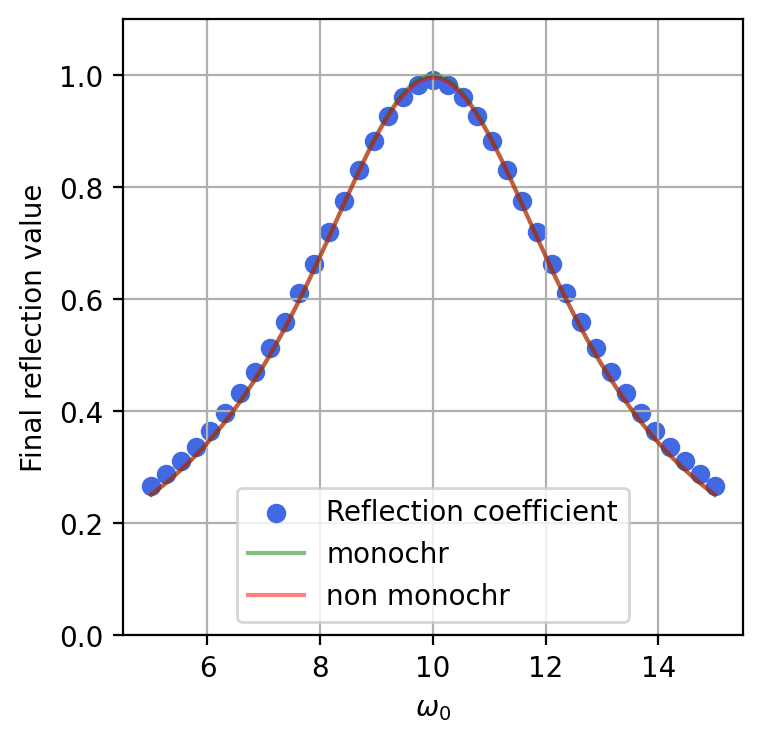

In [24]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=resol)
ax.scatter(omega_0_tab, 1-p_1_tab, marker='o', color="royalblue", label='Reflection coefficient')
ax.plot(omega_0_tab_theory, theory_curve, color="green", alpha=0.5, label="monochr")
ax.plot(omega_0_tab_theory, theory_curve_non_mono, color="red", alpha=0.5, label="non monochr")
ax.legend()
ax.set_xlabel(r'$\omega_0$')
ax.set_ylabel('Final reflection value')
ax.set_ylim(0, 1.1)
ax.grid()
plt.show()

Check the reflection coef at 50:50 BS

In [25]:
omega_0_p = omega_A_phys + 1*g_0_phys**2 * omega_A_phys 

c_array, b_array, overlap_tab, k_tab = get_data_mirror_fast(L, T, dt, omega_0_p, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes=False, progress_bar=False)
n_modes = len(k_tab)
p_transmission = np.sum(np.abs(c_array[-1, :n_modes])**2) 

print("At omega_0 =",  omega_0_p ," R = ", 1-p_transmission)

Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
At omega_0 = 12.894736842105264  R =  0.5139621789049551
